In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.modeling import models, fitting
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, ManualInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, gaussian
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline, interp1d

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"

In [3]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_1s_proto.h5", 'r') as hf:
    bias_dc_green_1s = hf['image'][:]

with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_3s_proto.h5", 'r') as hf:
    bias_dc_green_3s = hf['image'][:]

In [4]:
helium_im_collection = ImageFileCollection(green_path,
                            glob_include="HeliumGreenpoint1s_2465*.fit")
helium_im_df = helium_im_collection.summary.to_pandas()

In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

(300.0, 750.0)

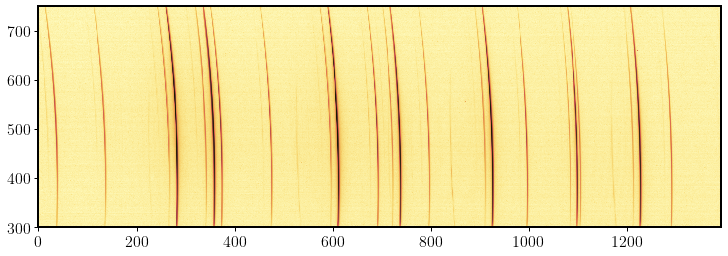

In [6]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
yaxis_slice = slice(300,750)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

(1285.0, 1300.0)

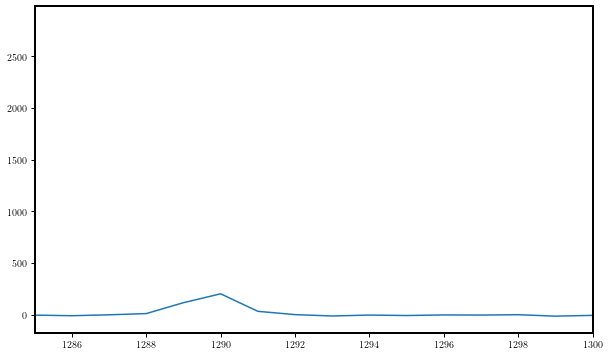

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1392), np.mean(helium_im_aver[300:305,:],axis=0))
ax.set_xlim(1285,1300)

In [8]:
class TraceSingleCurvature:
    def __init__(self,image, init_start, init_end, xarray = None,ybin=5,plot_fit=None):
        self.nbins = int(image.shape[0]/ybin)
        self.xpos = np.zeros(self.nbins)
        self.xwidth = np.zeros(self.nbins)
        self.xpos_err = np.zeros(self.nbins)
        self.xwidth_err = np.zeros(self.nbins)
        if xarray is None:
            self.xarray = np.arange(image.shape[1])
        
        self.wvl_region_half_length = int(np.ceil((init_end - init_start)/2))
        first_bin_slice = slice(init_start,init_end)
        first_bin = np.mean(image[:ybin,first_bin_slice],axis=0)
        
        xpos_guess = init_start + np.argmax(first_bin)
        popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[first_bin_slice],ydata=first_bin, 
                    p0=[self.xarray[xpos_guess], first_bin[xpos_guess - first_bin_slice.start]*2, 2, 0])

        self.xpos[0] = popt[0]
        self.xpos_err[0] = np.sqrt(pcov[0,0])
        self.xwidth[0] = popt[2]
        self.xwidth_err[0] = np.sqrt(pcov[2,2])

        for ii in range(1,self.nbins):
            ii_slice = slice(int(np.rint(self.xpos[ii - 1]) - self.wvl_region_half_length),
                            int(np.rint(self.xpos[ii - 1]) + self.wvl_region_half_length))
            ii_bin = np.mean(image[int(ii*ybin):int((ii+1)*ybin),ii_slice],axis=0)
            xpos_guess = ii_slice.start + np.argmax(ii_bin)

            popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[ii_slice],ydata=ii_bin, 
                    p0=[self.xarray[xpos_guess], ii_bin[xpos_guess - ii_slice.start]*2, 2, 0])

            self.xpos[ii] = popt[0]
            self.xpos_err[ii] = np.sqrt(pcov[0,0])
            self.xwidth[ii] = popt[2]
            self.xwidth_err[ii] = np.sqrt(pcov[2,2])

            if plot_fit is not None:
                if ii in plot_fit:
                    fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
                    ax.step(self.xarray[ii_slice], ii_bin,where="mid")
                    ax.plot(np.linspace(self.xarray[ii_slice][0], self.xarray[ii_slice][-1],50),
                            gaussian_bg(np.linspace(self.xarray[ii_slice][0], self.xarray[ii_slice][-1],50), 
                            *popt))
                    ax.text(0.02,0.97,r"$\Delta \lambda = {:.2f} \pm {:.2f}$".format(popt[2],self.xwidth_err[ii]),fontsize=16,transform=ax.transAxes,
                            va="top",ha="left")

        
def gaussian_bg(wvl, line_wvl, int_total, fwhm, bg):
    return gaussian(wvl, line_wvl=line_wvl, int_total=int_total, fwhm=fwhm) + bg




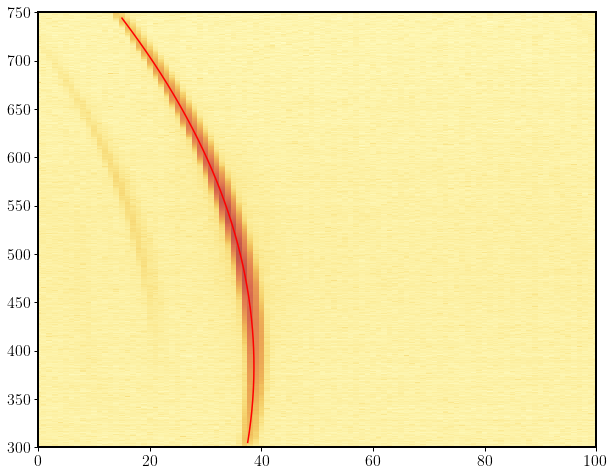

In [9]:
test_1 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=30,init_end=45)


fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_1_curve = test_1.xpos
test_1_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(0,100)

test_1_spl = UnivariateSpline(test_1_ypix, test_1_curve)
ax.plot(test_1_spl(np.arange(305,745)),np.arange(305,745),color="red")

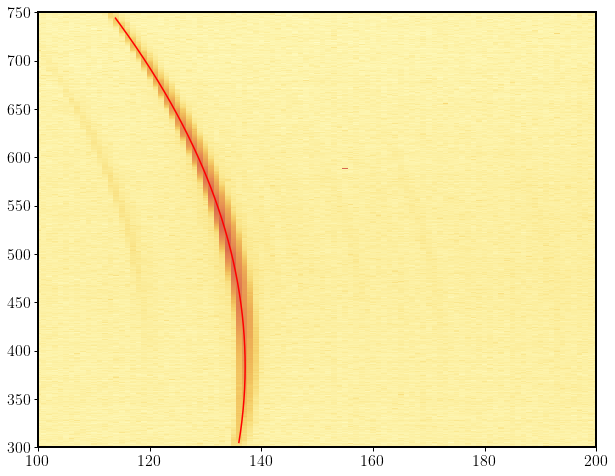

In [10]:
test_2 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=130,init_end=145)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_2_curve = test_2.xpos
#ax.step(test_1_curve, tsest_1_ypix, color="white",alpha=0.7)
ax.set_xlim(100,200)

test_2_spl = UnivariateSpline(test_1_ypix, test_2_curve)
ax.plot(test_2_spl(np.arange(305,745)),np.arange(305,745),color="red")

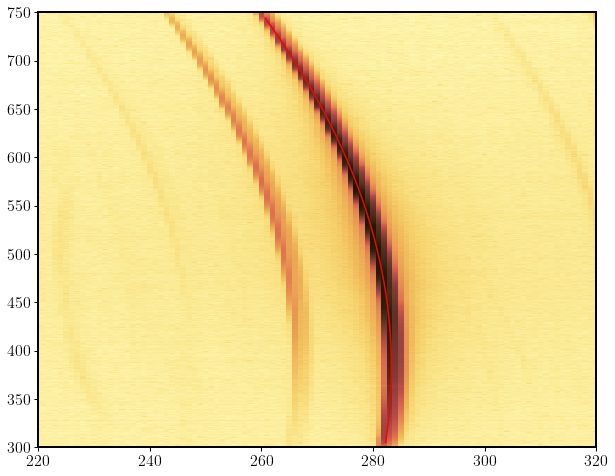

In [11]:
test_3 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=275,init_end=290)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_3_curve = test_3.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(220,320)

test_3_spl = UnivariateSpline(test_1_ypix, test_3_curve)
ax.plot(test_3_spl(np.arange(305,745)),np.arange(305,745),color="red")

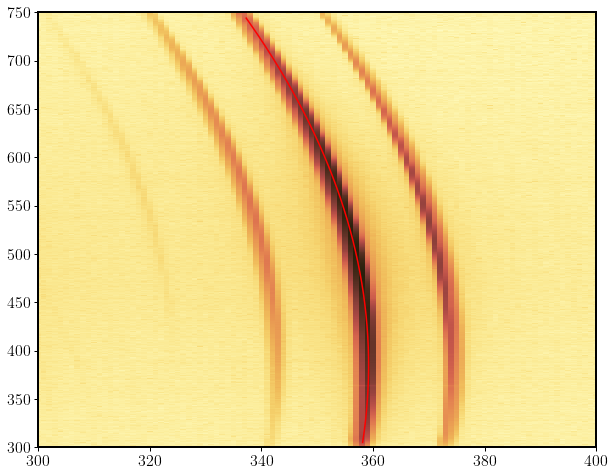

In [12]:
test_4 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=350,init_end=365)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_4_curve = test_4.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(300,400)

test_4_spl = UnivariateSpline(test_1_ypix, test_4_curve)
ax.plot(test_4_spl(np.arange(305,745)),np.arange(305,745),color="red")

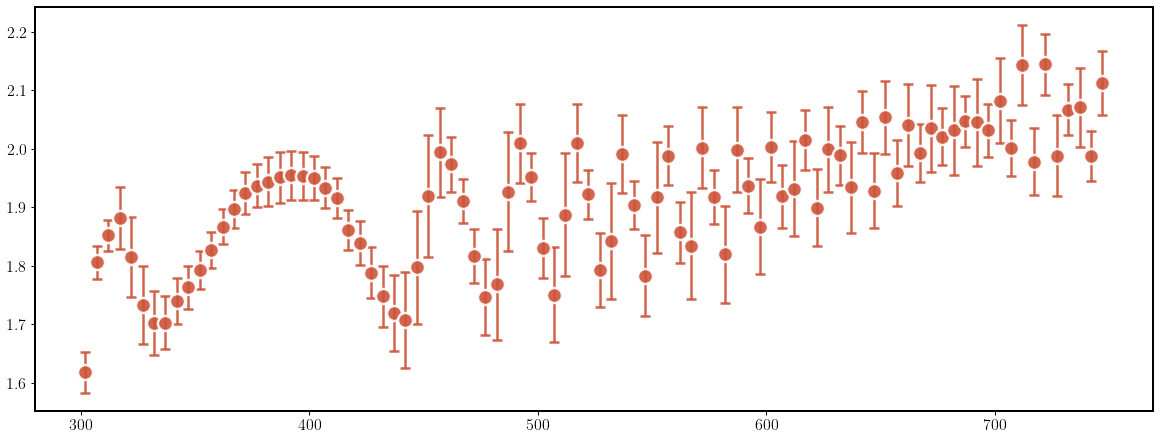

In [13]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_4.xwidth,test_4.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5)
ax.tick_params(labelsize=16)

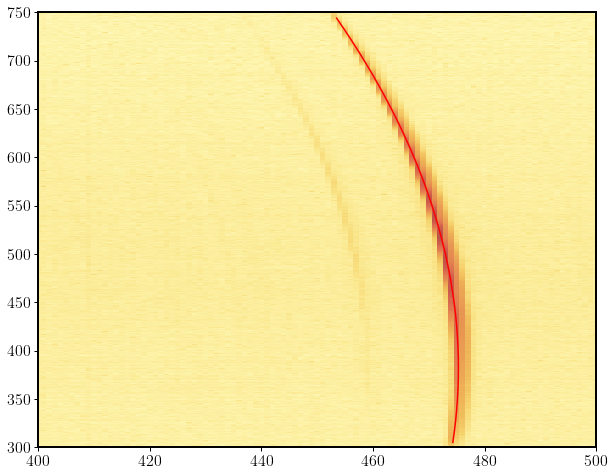

In [14]:
test_5 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=465,init_end=480)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_5_curve = test_5.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(400,500)

test_5_spl = UnivariateSpline(test_1_ypix, test_5_curve)
ax.plot(test_5_spl(np.arange(305,745)),np.arange(305,745),color="red")

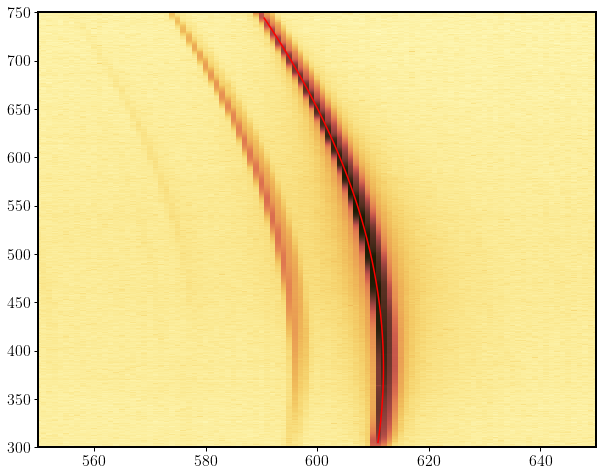

In [15]:
test_6 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=605,init_end=620)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_6_curve = test_6.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(550,650)

test_6_spl = UnivariateSpline(test_1_ypix, test_6_curve)
ax.plot(test_6_spl(np.arange(305,745)),np.arange(305,745),color="red")

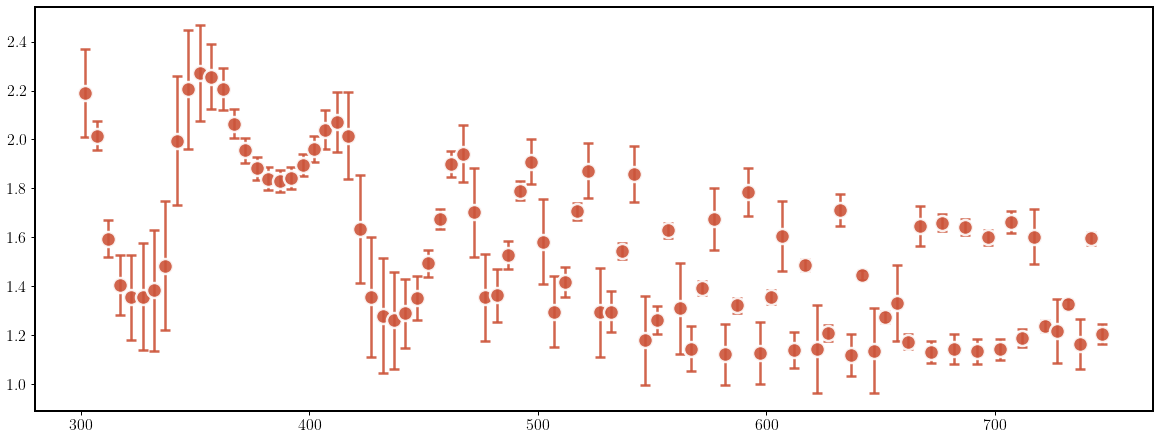

In [16]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_6.xwidth,test_6.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5)
ax.tick_params(labelsize=16)

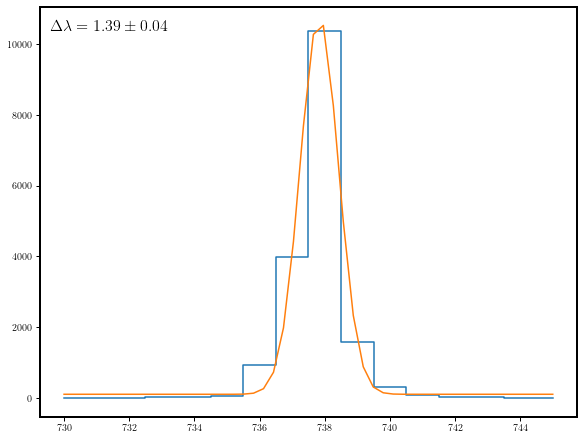

In [17]:
test_7 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=730,init_end=745,plot_fit=[4])

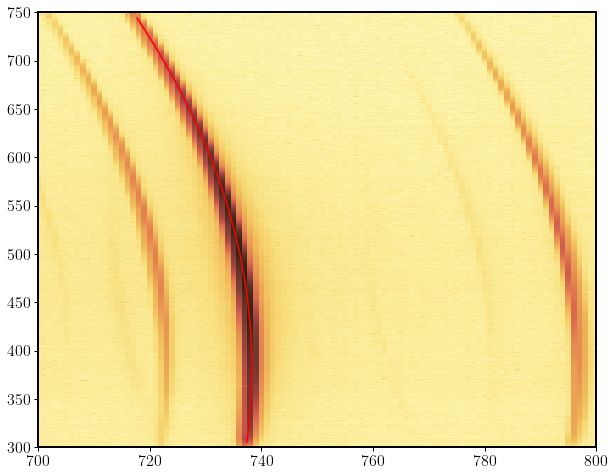

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_7_curve = test_7.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(700,800)

test_7_spl = UnivariateSpline(test_1_ypix, test_7_curve)
ax.plot(test_7_spl(np.arange(305,745)),np.arange(305,745),color="red")

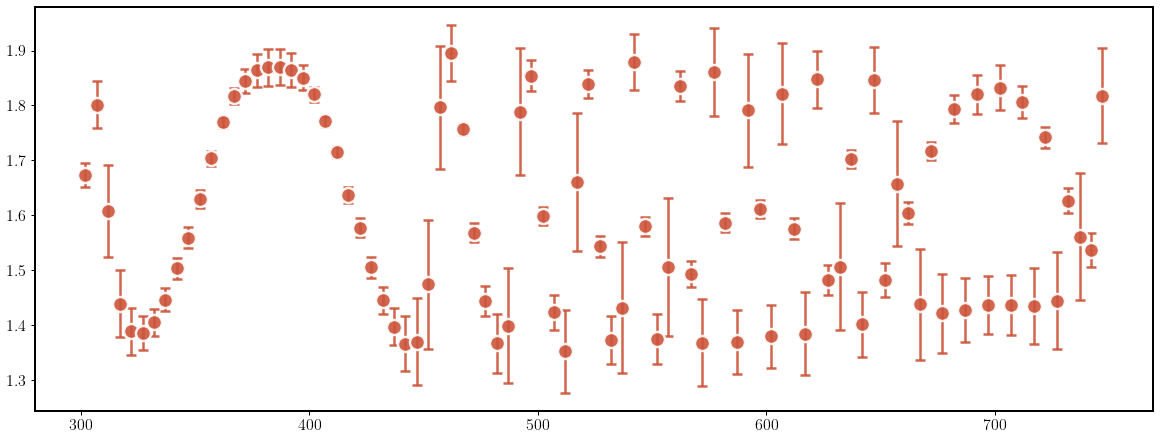

In [19]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_7.xwidth,test_7.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5)
ax.tick_params(labelsize=16)

In [20]:
with h5py.File("../../sav/Eclipse/InstWidth/HeI_D3_2_width_green_curcorr.h5", 'r') as hf:
    HeI_D3_fwhm_curcorr = hf["HeI_D3_fwhm"][:][:,0]
    HeI_D3_fwhm_curcorr_err = hf["HeI_D3_fwhm_err"][:][:,0]

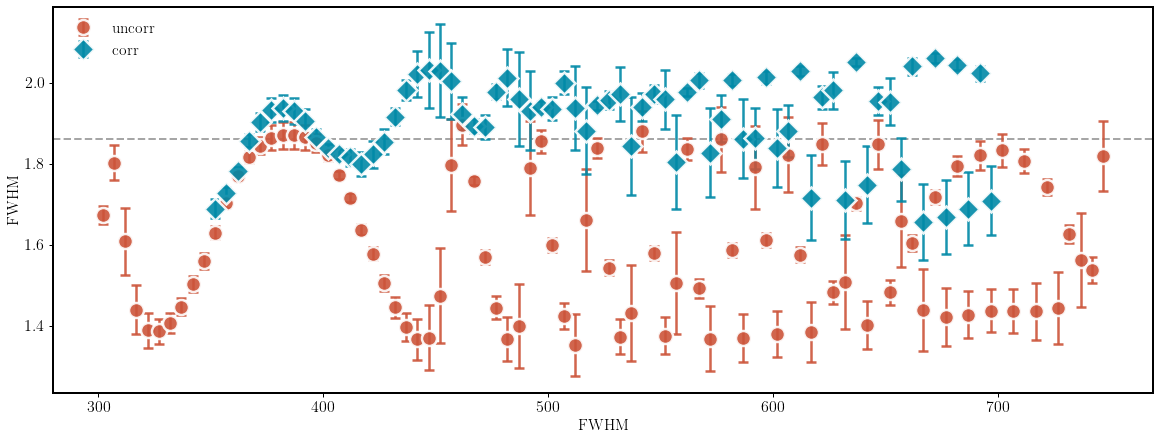

In [21]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_7.xwidth,test_7.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5,label="uncorr")
ax.errorbar(np.arange(352, 700, 5), HeI_D3_fwhm_curcorr, HeI_D3_fwhm_curcorr_err, 
            color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5,label=r"corr")
ax.tick_params(labelsize=16)
ax.set_ylabel("FWHM",fontsize=16)
ax.set_xlabel("FWHM",fontsize=16)
ax.axhline(1.86,color="grey",ls="--",lw=2,alpha=0.7,zorder=0)
plt.legend(fontsize=16,loc="upper left",frameon=False)

In [22]:
with h5py.File("../../sav/Eclipse/InstWidth/HeI_D3_2_width_green_uncorr.h5", 'w') as hf:
    df_HeI_D3_fwhm_uncorr = hf.create_dataset("HeI_D3_fwhm_uncorr",  data=test_7.xwidth)
    df_HeI_D3_fwhm_uncorr_err = hf.create_dataset("HeI_D3_fwhm_uncorr_err",  data=test_7.xwidth_err)
    df_HeI_D3_fwhm_ccdy = hf.create_dataset("HeI_D3_fwhm_ccdy",  data=test_1_ypix)

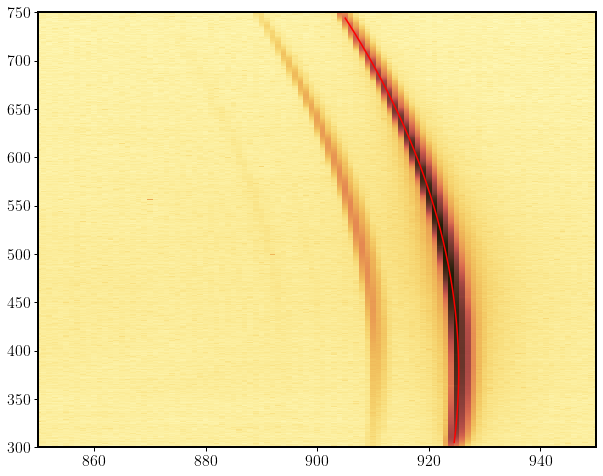

In [23]:
test_8 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=915,init_end=930)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_8_curve = test_8.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(850,950)

test_8_spl = UnivariateSpline(test_1_ypix, test_8_curve)
ax.plot(test_8_spl(np.arange(305,745)),np.arange(305,745),color="red")

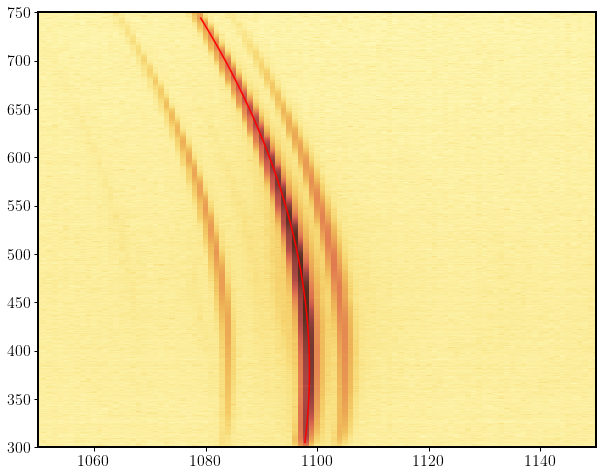

In [24]:
test_9 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1090,init_end=1105)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_9_curve = test_9.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1050,1150)

test_9_spl = UnivariateSpline(test_1_ypix, test_9_curve)
ax.plot(test_9_spl(np.arange(305,745)),np.arange(305,745),color="red")

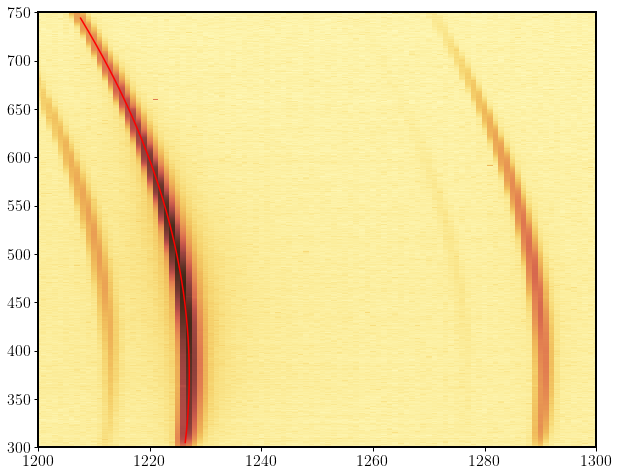

In [25]:
test_10 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1220,init_end=1235)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_10_curve = test_10.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1200,1300)

test_10_spl = UnivariateSpline(test_1_ypix, test_10_curve)
ax.plot(test_10_spl(np.arange(305,745)),np.arange(305,745),color="red")

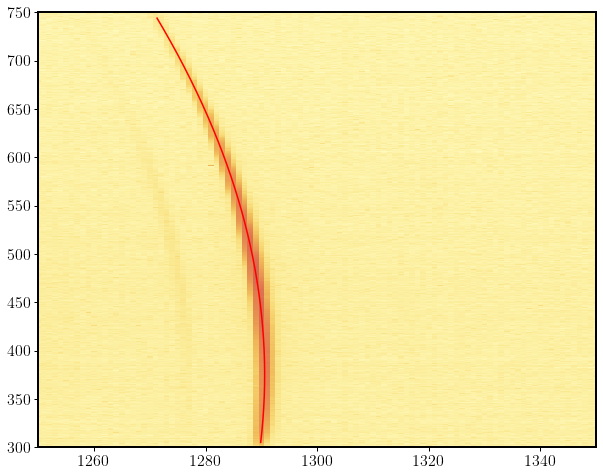

In [26]:
test_11 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1285,init_end=1300)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_11_curve = test_11.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1250,1350)

test_11_spl = UnivariateSpline(test_1_ypix, test_11_curve)
ax.plot(test_11_spl(np.arange(305,745)),np.arange(305,745),color="red")

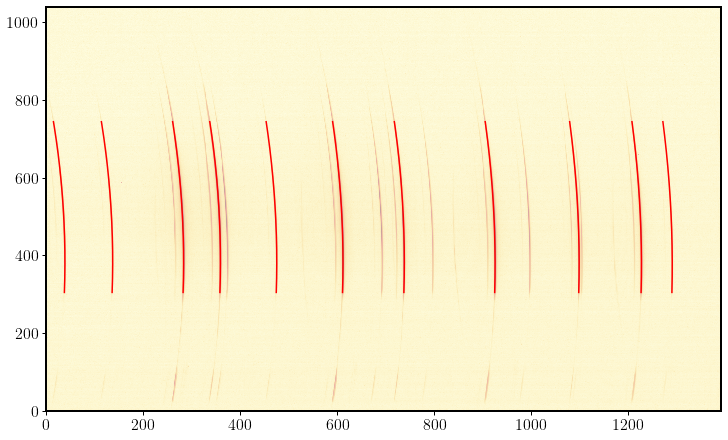

In [27]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls = (test_1_spl,test_2_spl,test_3_spl,test_4_spl,test_5_spl,
            test_6_spl,test_7_spl,test_8_spl,test_9_spl,test_10_spl,
            test_11_spl)
for spl_ in spls :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")

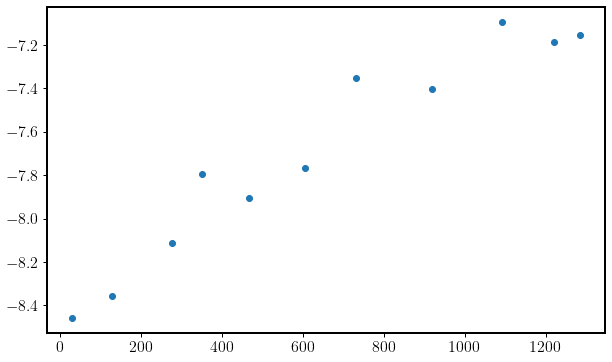

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
xpos_y600 = np.array([spl_(600) for spl_ in spls])
xpos_y400 = np.array([spl_(400) for spl_ in spls])
xshift_y600 = xpos_y600 - xpos_y400
ax.scatter(xpos_y600, xshift_y600)
ax.tick_params(labelsize=16)

In [29]:
spls_all = (test_1_spl, test_2_spl, test_3_spl,
            test_4_spl, test_5_spl, test_6_spl,
            test_7_spl, test_8_spl, test_9_spl,
            test_10_spl, test_11_spl)
ypos_tofit = np.tile(np.arange(305,745,dtype=np.float64),(11,1)).T
xpos_tofit = np.zeros_like(ypos_tofit,dtype=np.float64)
for ii, spl_ in enumerate(spls_all):
    xpos_tofit[:,ii] = spl_(ypos_tofit[:,ii])
xshift_tofit = xpos_tofit - xpos_tofit[95,:]

Text(0, 0.5, 'X-shift [Pixel]')

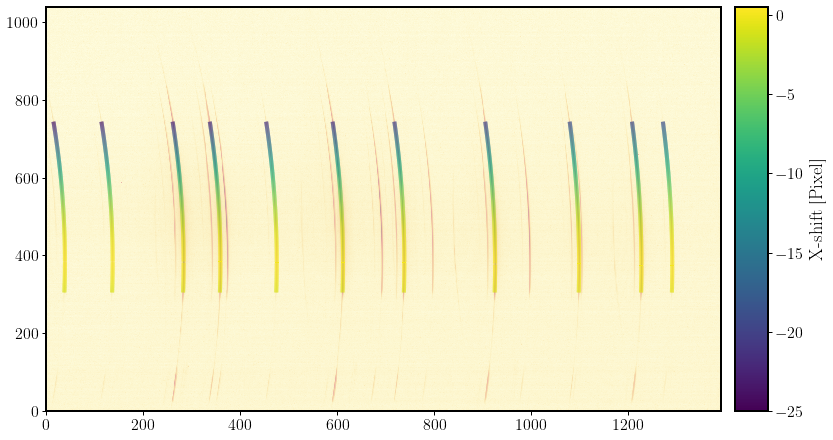

In [30]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls = (test_1_spl,test_2_spl,test_3_spl,test_4_spl,test_5_spl,
            test_6_spl,test_7_spl,test_8_spl,test_9_spl,test_10_spl,
            test_11_spl)
for spl_ in spls :
    points_ = np.array([spl_(np.arange(305,745,dtype=np.float64)), np.arange(305,745)]).T.reshape(-1,1,2)
    segments_ = np.concatenate([points_[:-1],points_[1:]],axis=1)
    shift_toplot_ = spl_(np.arange(305,745,dtype=np.float64)) - spl_(400)
    segments_norm_ = plt.Normalize(-25,0.5)
    lc_ = LineCollection(segments_, cmap="viridis",norm=segments_norm_)
    lc_.set_array(shift_toplot_)
    lc_.set_linewidth(4)
    line_ = ax.add_collection(lc_)
    # ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red", )

clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(line_,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('X-shift [Pixel]',fontsize=18)

In [31]:
chebyshev2d_init = models.Chebyshev2D(x_degree=1,y_degree=2)
fit_chebyshev2d = fitting.LevMarLSQFitter()
chebyshev2d_p = fit_chebyshev2d(chebyshev2d_init,xpos_tofit, ypos_tofit, xshift_tofit)

In [32]:
ypos_tofit_new = np.tile(test_1_ypix,(11,1)).T

xpos_tofit_new = np.stack((test_1_curve, test_2_curve, test_3_curve,
            test_4_curve, test_5_curve, test_6_curve,
            test_7_curve, test_8_curve, test_9_curve,
            test_10_curve, test_11_curve)).T
xshift_tofit_new = xpos_tofit_new - xpos_tofit_new[20,:]

In [33]:
chebyshev2d_p_new = fit_chebyshev2d(chebyshev2d_init,xpos_tofit_new, ypos_tofit_new, xshift_tofit_new)

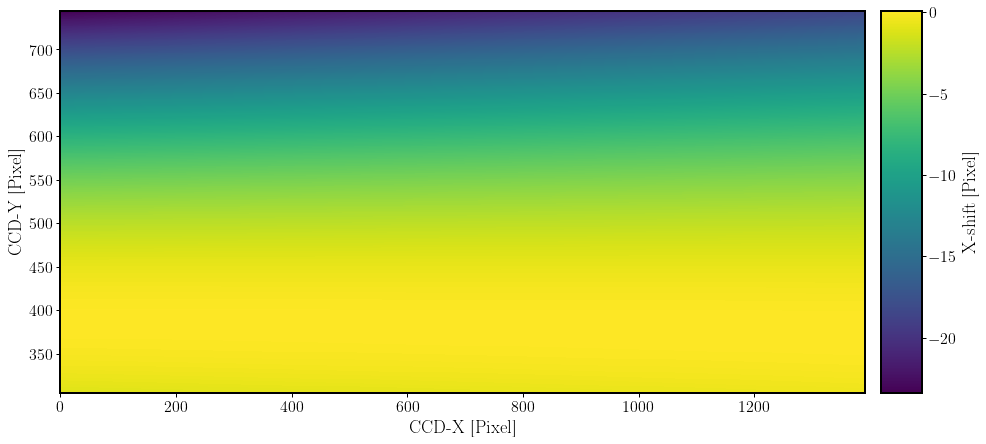

In [34]:
ypos_plot, xpos_plot = np.mgrid[305:745,:1392]
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
im = ax.pcolormesh(xpos_plot, ypos_plot, chebyshev2d_p(xpos_plot, ypos_plot),rasterized=True)

testx_slice = slice(100,200)
testy_slice = slice(350,700)

test_rectangle = Rectangle((testx_slice.start, testy_slice.start), 
                    testx_slice.stop - testx_slice.start,
                    testy_slice.stop - testy_slice.start,
                    edgecolor="red",facecolor='none',lw=2)

# ax.add_patch(test_rectangle)

ax.tick_params(labelsize=16)
ax.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax.set_ylabel("CCD-Y [Pixel]",fontsize=18)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('X-shift [Pixel]',fontsize=18)
plt.savefig(fname="../../figs/calib/curvature_2d_fit_green.png",format="png",dpi=150,bbox_inches="tight")

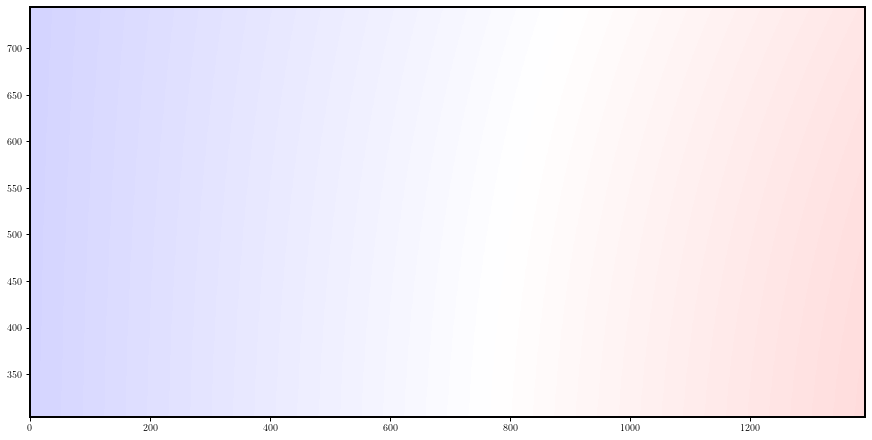

In [35]:
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
im = ax.pcolormesh(xpos_plot, ypos_plot, chebyshev2d_p(xpos_plot, ypos_plot) - \
                                                chebyshev2d_p_new(xpos_plot, ypos_plot),
                                                rasterized=True,vmin=-0.1,vmax=0.1,cmap="bwr")

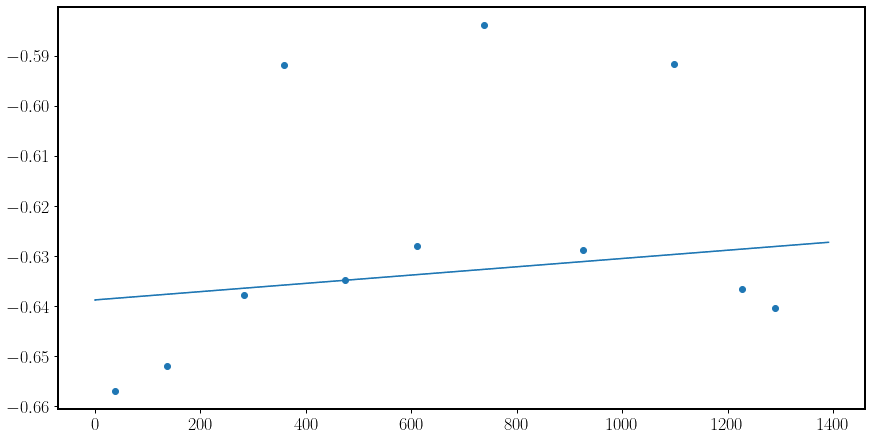

In [36]:
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
ax.step(np.arange(1392), chebyshev2d_p(np.arange(1392), 446*np.ones(1392)))
ax.scatter(xpos_tofit[141,:],xshift_tofit[141,:])
ax.tick_params(labelsize=18)

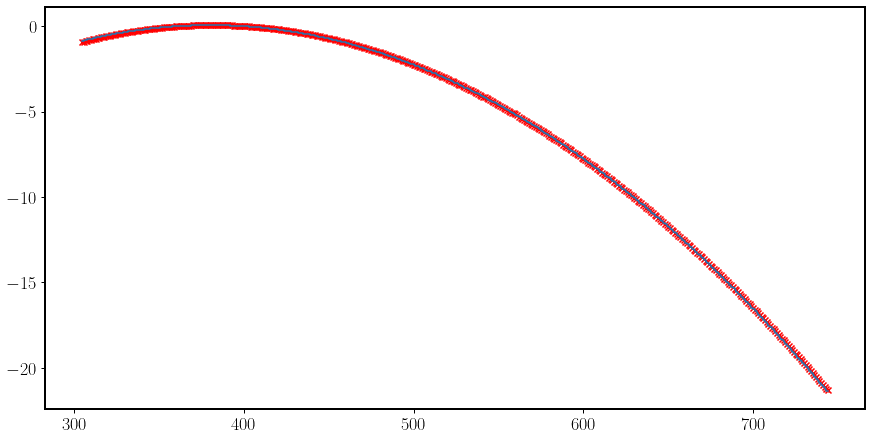

In [37]:
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
ax.step(np.arange(305,745), chebyshev2d_p(xpos_tofit[:,5], np.arange(305,745)))
ax.scatter(ypos_tofit[:,5],xshift_tofit[:,5],color="red",marker="x")
ax.tick_params(labelsize=18)

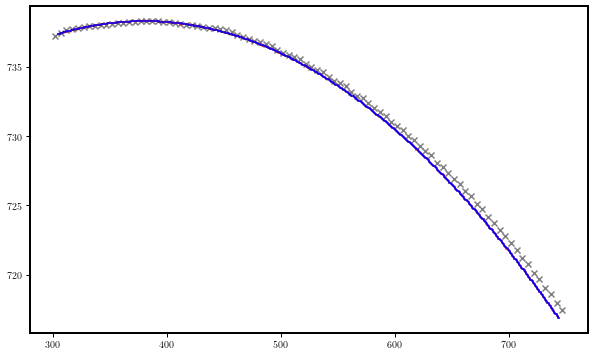

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.step(np.arange(305,745), chebyshev2d_p(xpos_tofit[:,5], np.arange(305,745))+ xpos_tofit[95,6],color="red") 
ax.step(np.arange(305,745), chebyshev2d_p_new(xpos_tofit[:,5], np.arange(305,745))+ xpos_tofit[95,6],color="blue") 
ax.scatter(test_1_ypix, test_7_curve,marker="x",color="grey")
# ax.plot(np.arange(305,745), test_7_spl(np.arange(305,745)),color="red")

In [39]:
testx_slice_mapcoor = slice(40,1350)
testy_slice_mapcoor = slice(350,700)
ypos_map_coordinate, xpos_map_coordinate = np.mgrid[testy_slice_mapcoor,testx_slice_mapcoor]
xpos_map_coordinate = xpos_map_coordinate + chebyshev2d_p_new(xpos_map_coordinate, ypos_map_coordinate)

xpos_map_coordinate = xpos_map_coordinate - testx_slice_mapcoor.start
ypos_map_coordinate = ypos_map_coordinate - testy_slice_mapcoor.start


In [40]:
xpos_map_coordinate.shape

(350, 1310)

In [41]:
def correct_curvature(data,xpos_map_coordinate):
    data_shape = data.shape
    data_interp = np.zeros(data_shape)
    for ii in range(data_shape[0]):
        f = interp1d(xpos_map_coordinate[50,:],data[ii,:],kind="linear",fill_value="extrapolate")
        data_interp[ii,:] = f(xpos_map_coordinate[ii,:])
    
    return data_interp

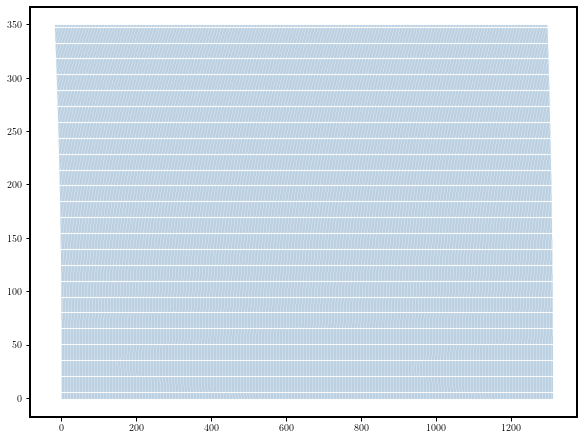

In [42]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.scatter(xpos_map_coordinate.flat,ypos_map_coordinate.flat,s=0.001)

In [43]:
helium_trans_mapcoor = ndimage.map_coordinates(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                            order=1)

In [44]:
helium_trans_mapcoor_2 = correct_curvature(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],xpos_map_coordinate)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'Corrected Helium Frame')

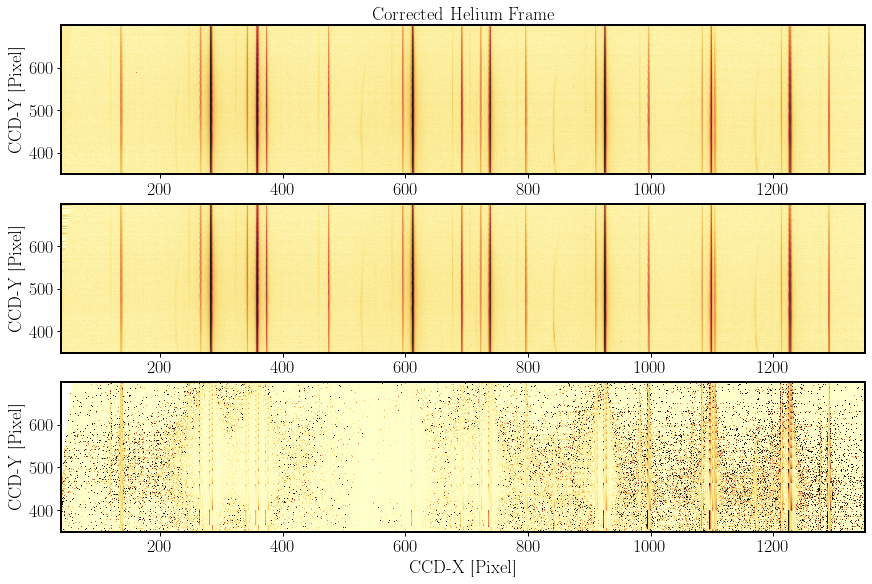

In [45]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)

im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor_2,norm=norm,cmap=cmcm.lajolla,rasterized=True)

im3 = ax3.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            np.abs(helium_trans_mapcoor_2 - helium_trans_mapcoor)/helium_trans_mapcoor*100,vmin=0,vmax=10,cmap=cmcm.lajolla,rasterized=True)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelsize=18)
    ax_.set_ylabel("CCD-Y [Pixel]",fontsize=18)


ax3.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax1.set_title("Corrected Helium Frame",fontsize=18)

# clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
#                 bbox_to_anchor=(1.02, 0., 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0)
# clb = plt.colorbar(im,orientation='vertical',ax=ax,cax=clb_ax)
# clb_ax.tick_params(labelsize=16)
# clb_ax.yaxis.get_offset_text().set_fontsize(16)
# clb_ax.set_ylabel('',fontsize=16)

(580.0, 620.0)

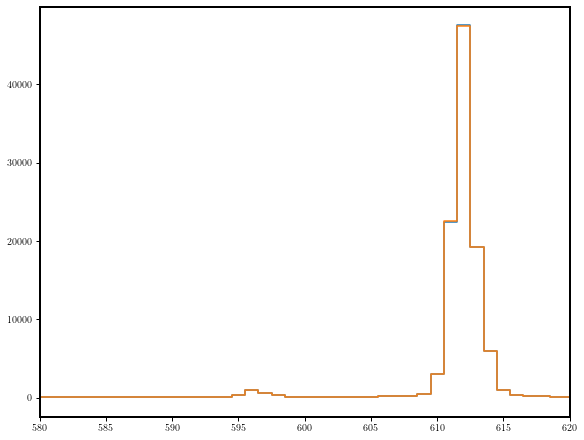

In [46]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.step(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop), helium_trans_mapcoor[100,:],where="mid")
ax.step(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop), helium_trans_mapcoor_2[100,:],where="mid")
ax.set_xlim(580,620)

In [47]:
hydrogen_im_collection = ImageFileCollection(green_path,
                            glob_include="HydrogenGreen5s_2477*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_3s

hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
hydrogen_trans_mapcoor = ndimage.map_coordinates(hydrogen_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),order=1)

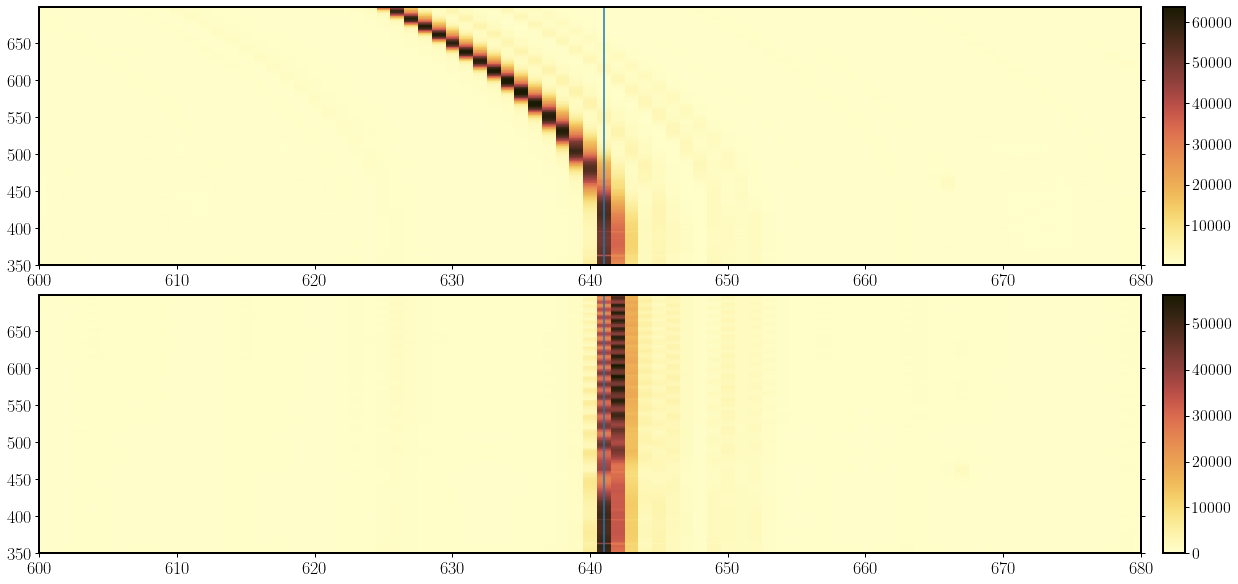

In [48]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            hydrogen_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla,rasterized=True)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            hydrogen_trans_mapcoor,cmap=cmcm.lajolla,rasterized=True)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.set_xlim(600,680)
    ax_.tick_params(labelsize=18,right=True)
    ax_.axvline(641)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

In [49]:
mylar_im_collection = ImageFileCollection(green_path,
                            glob_include="SunMylarGreenpoint1s_2080*.fit")
mylar_im_df = mylar_im_collection.summary.to_pandas()

In [50]:
mylar_image_cube = np.zeros((1040,1392,10))

for ii, row_ in mylar_im_df.iterrows():
    mylar_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

mylar_im_aver = np.mean(mylar_image_cube,axis=2)

In [51]:
mylar_trans_mapcoor = ndimage.map_coordinates(mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),order=1)

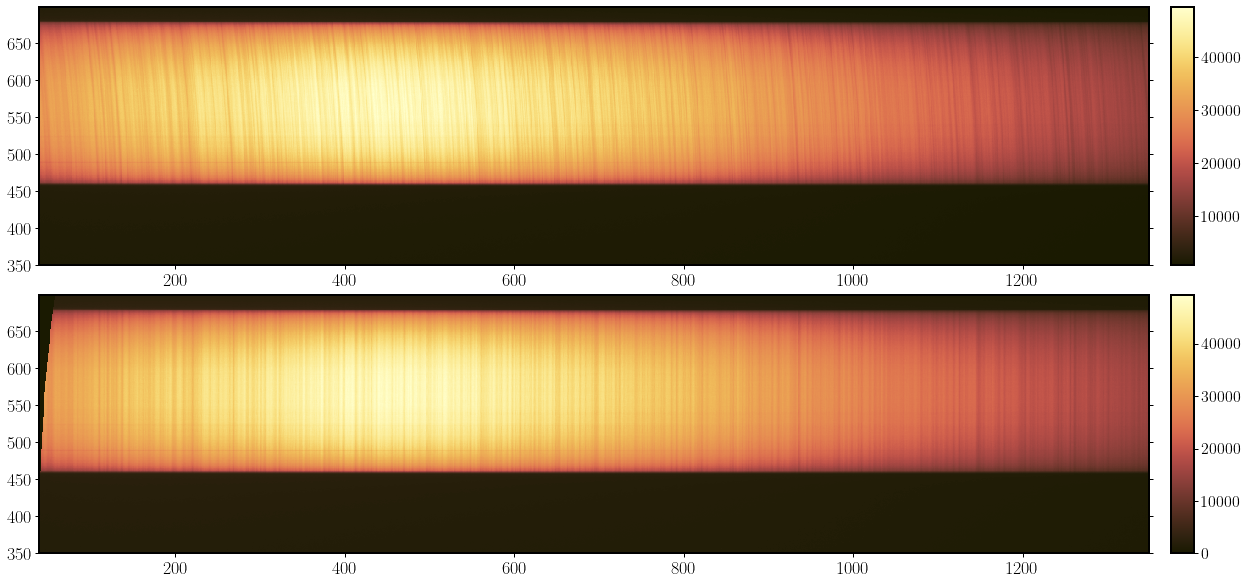

In [52]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

Text(0, 0.5, '')

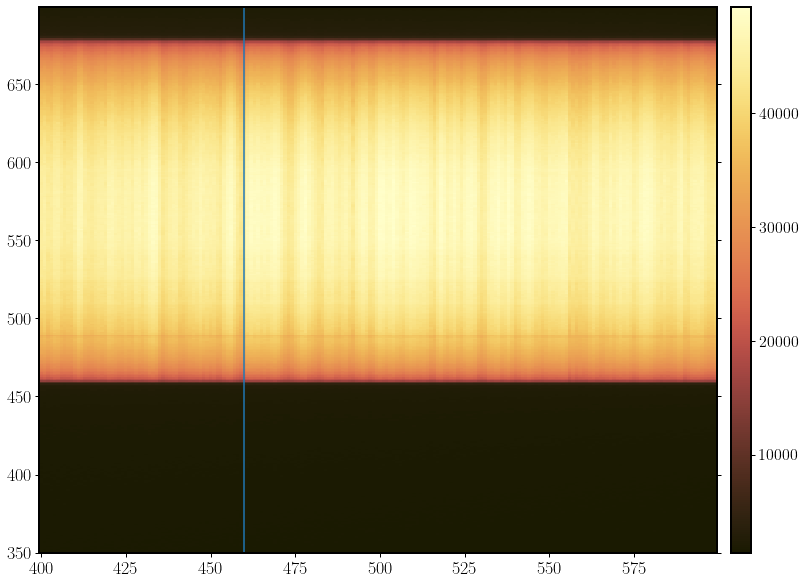

In [53]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(400,600),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor[:,300:500],cmap=cmcm.lajolla_r,rasterized=True)
ax.tick_params(labelsize=18,right=True)
ax.axvline(460)
clb_ax = inset_axes(ax,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [54]:
skyflat_im_collection = ImageFileCollection(green_path,
                            glob_include="SkyGreen1s-better(lightleakcovered)_2286*.fit")
skyflat_im_df = skyflat_im_collection.summary.to_pandas()
skyflat_im_df

file  simple  bitpix  naxis  \
0  SkyGreen1s-better(lightleakcovered)_22861.fit    True      16      2   
1  SkyGreen1s-better(lightleakcovered)_22862.fit    True      16      2   
2  SkyGreen1s-better(lightleakcovered)_22863.fit    True      16      2   
3  SkyGreen1s-better(lightleakcovered)_22864.fit    True      16      2   
4  SkyGreen1s-better(lightleakcovered)_22865.fit    True      16      2   
5  SkyGreen1s-better(lightleakcovered)_22866.fit    True      16      2   
6  SkyGreen1s-better(lightleakcovered)_22867.fit    True      16      2   
7  SkyGreen1s-better(lightleakcovered)_22868.fit    True      16      2   
8  SkyGreen1s-better(lightleakcovered)_22869.fit    True      16      2   

   naxis1  naxis2    bzero  bscale  datamin  datamax  ... ypixsz  xbinning  \
0    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
1    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
2    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
3    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
4    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
5    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
6    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
7    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   
8    1392    1040  32768.0     1.0      0.0  65535.0  ...   6.45         1   

  ybinning  xorgsubf  yorgsubf  xpossubf  ypossubf  cblack  cwhite  \
0        1         0         0         0         0    1470    8611   
1        1         0         0         0         0    1475    8626   
2        1         0         0         0         0    1470    8620   
3        1         0         0         0         0    1479    8630   
4        1         0         0         0         0    1467    8626   
5        1         0         0         0         0    1478    8639   
6        1         0         0         0         0    1471    8636   
7        1         0         0         0         0    1469    8641   
8        1         0         0         0         0    1476    8650   

          swcreate  
0  Artemis Capture  
1  Artemis Capture  
2  Artemis Capture  
3  Artemis Capture  
4  Artemis Capture  
5  Artemis Capture  
6  Artemis Capture  
7  Artemis Capture  
8  Artemis Capture  

[9 rows x 24 columns]

In [55]:
skyflat_image_cube = np.zeros((1040,1392,9))

for ii, row_ in skyflat_im_df.iterrows():
    skyflat_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

skyflat_im_aver = np.mean(skyflat_image_cube,axis=2)

In [56]:
skyflat_trans_mapcoor = ndimage.map_coordinates(skyflat_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                        order=1)

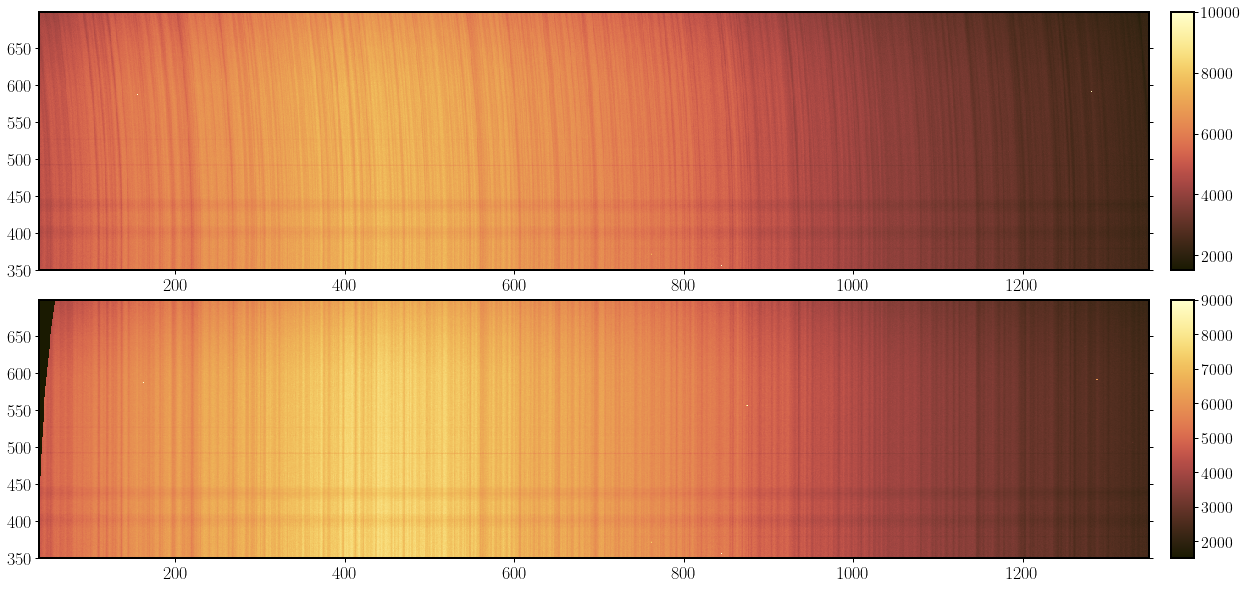

In [57]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            skyflat_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True,vmin=1500,vmax=10000)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            skyflat_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True,vmin=1500,vmax=9000)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)
plt.savefig(fname="../../figs/calib/skyflat_curvature_corr_green.png",format="png",dpi=150,bbox_inches="tight")

In [58]:
totality_image = CCDData.read(os.path.join(green_path,"TotalitySequenceGreen_22718(3).fit"),unit="adu").data - bias_dc_green_1s

In [59]:
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

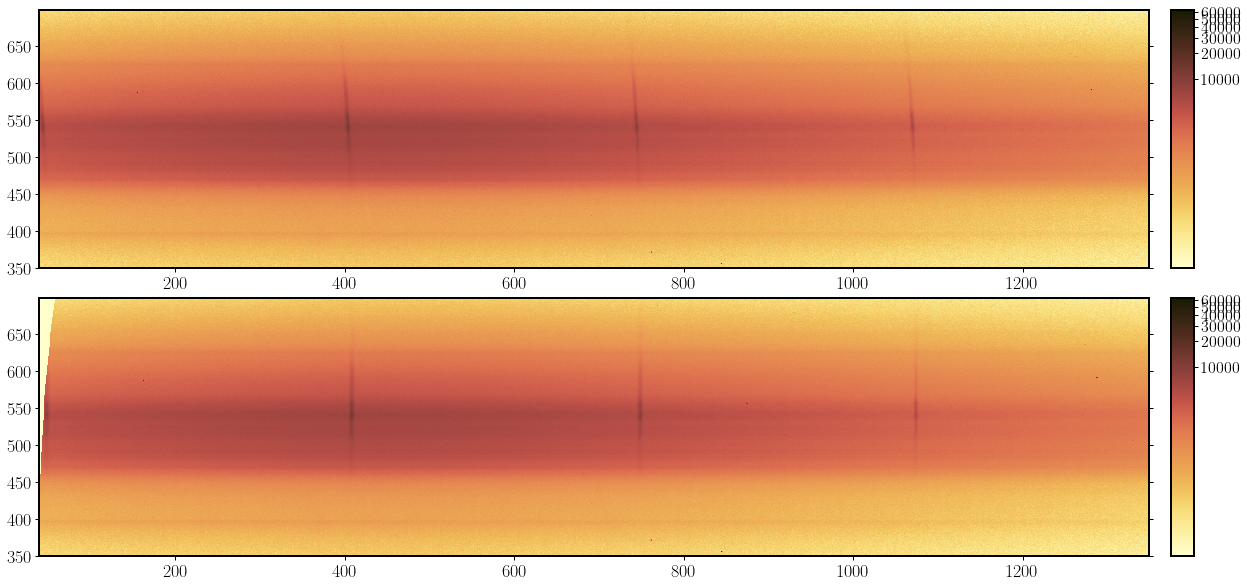

In [60]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
norm_totality = ImageNormalize(totality_image[testy_slice_mapcoor, testx_slice_mapcoor], stretch=LogStretch())
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_image[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla,rasterized=True,norm=norm_totality)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,cmap=cmcm.lajolla,rasterized=True,norm=norm_totality)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,pad = 0.05,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

In [61]:
totality_trans_mapcoor.shape

(350, 1310)

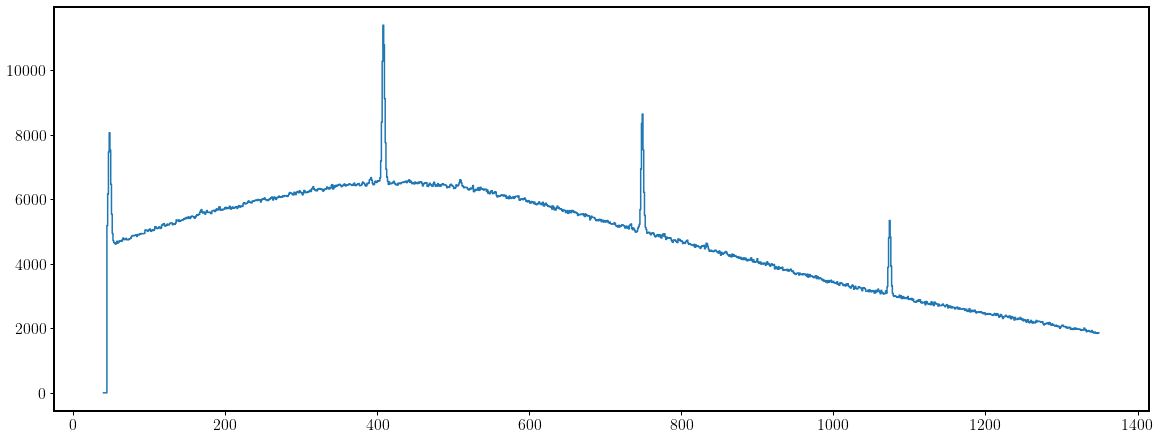

In [62]:
totality_spectrum_1d = np.mean(totality_trans_mapcoor[190:200,:],axis=0)
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.step(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),totality_spectrum_1d,where="mid")
ax.tick_params(labelsize=16)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:title={'center':'\\textbf{Fe \\textsc{xiv} 5303\\,\\mbox{\\AA}}'}, ylabel='Intensity'>

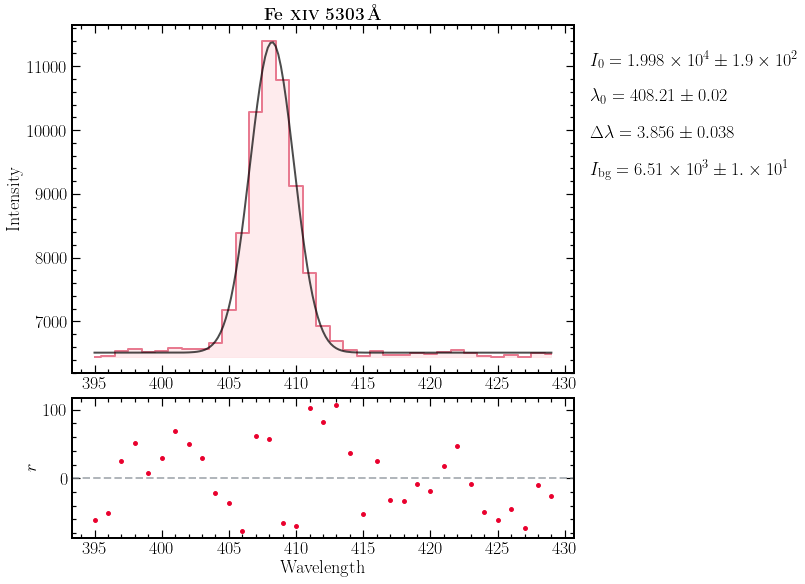

In [63]:
totality_spectrum_1d_zoomin_slice = slice(395-40,430-40)
totality_spectrum_1d_zoomin = totality_spectrum_1d[totality_spectrum_1d_zoomin_slice]
totality_spectrum_1d_x = np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop)[totality_spectrum_1d_zoomin_slice]

totality_spectrum_corr_fit = SpectrumFitSingle(data=totality_spectrum_1d_zoomin,wvl=totality_spectrum_1d_x,line_number=1,
                                            line_wvl_init=407,int_max_init=11000,fwhm_init=5,same_width=False,)
totality_spectrum_corr_fit.run_lse()                                    
totality_spectrum_corr_fit.plot(plot_fit=True,plot_title=r"\textbf{Fe \textsc{xiv} 5303\,\mbox{\AA}}")

In [64]:
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_green.h5", 'w') as hf:
    df_x = hf.create_dataset("xpos_map_coordinate",  data=xpos_map_coordinate)
    df_y = hf.create_dataset("ypos_map_coordinate",  data=ypos_map_coordinate)
    df_x.attrs["xstart_pixel"] = testx_slice_mapcoor.start
    df_x.attrs["xend_pixel"] = testx_slice_mapcoor.stop
    df_y.attrs["ystart_pixel"] = testy_slice_mapcoor.start
    df_y.attrs["yend_pixel"] = testy_slice_mapcoor.stop